# Компания ''1001 лотерейный билет" провела рассылку пользователям с новым макетом письма направленым на увеличение продаж в мобильном приложении

### Задача – сравнить 2 группы и ответить на вопрос: есть ли отличия в поведении участников в зависимости от макета?

**Описание данных:**
- `group` – Группа(control-без изменений, pilot-новый макет письма)
- `user_id` – id пользователя
- `flg_deliv_email` – флаг доставки письма до пользователя Email.
- `flg_read_email` – Было ли открыто Email письмо.
- `flg_open_link_email` – Был ли переход по Email (клик по ссылке/картинке в письме)
- `sales_mobile` – Продажи в мобильном приложении.
- `sales_total` – Траты пользователя во всех каналах (сайт, мобильный сайт, мобильное приложение, розничные торговые точки и т.д.)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu
import hashlib
import os

# Знакомство с данными

In [2]:
data = pd.read_csv(os.path.abspath('..') + '\\ab_data.csv')
data

,group,user_id,flg_deliv_email,flg_read_email,flg_open_link_email,sales_mobile,sales_total
0,control,5066305263,1,N,0,NaN,350.0
1,pilot,5070957036,1,N,0,NaN,NaN
2,control,5071201643,1,N,0,NaN,NaN
3,control,5071882995,1,N,0,NaN,NaN
4,control,5075332931,1,N,0,NaN,NaN
...,...,...,...,...,...,...,...
10457,control,7533107439282,1,N,0,NaN,NaN
10458,control,7533107447865,1,Y,0,NaN,NaN
10459,pilot,7533107448386,1,N,0,NaN,NaN
10460,pilot,7533239105308,1,N,0,NaN,NaN


In [3]:
data.columns

Index(['group', 'user_id', 'flg_deliv_email', 'flg_read_email',
       'flg_open_link_email', 'sales_mobile', 'sales_total'],
      dtype='object')

In [4]:
#смоттрим кол-во пользователей в группах
data['group'].value_counts()

control    5231
pilot      5231
Name: group, dtype: int64

In [5]:
#смотрим флаг доставки
data['flg_deliv_email'].value_counts()

1    10375
0       87
Name: flg_deliv_email, dtype: int64

In [6]:
#смотрим флаг прочтения письма
data['flg_read_email'].value_counts()

N    8056
Y    2406
Name: flg_read_email, dtype: int64

In [7]:
#флаг перехода по ссылке
data['flg_open_link_email'].value_counts()

0    9987
1     475
Name: flg_open_link_email, dtype: int64

## Посмотрим распределение пользователей

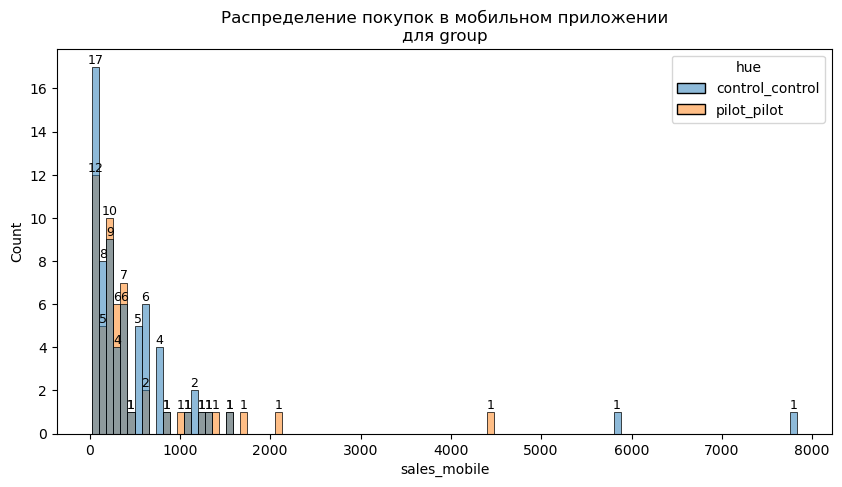

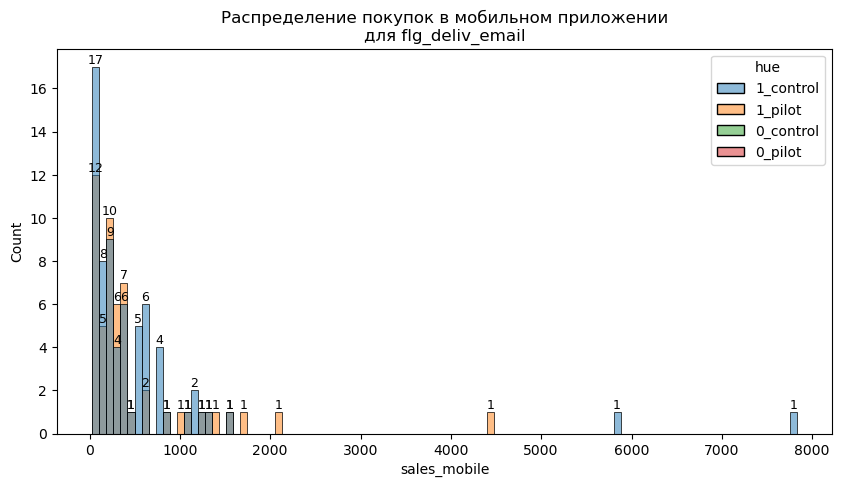

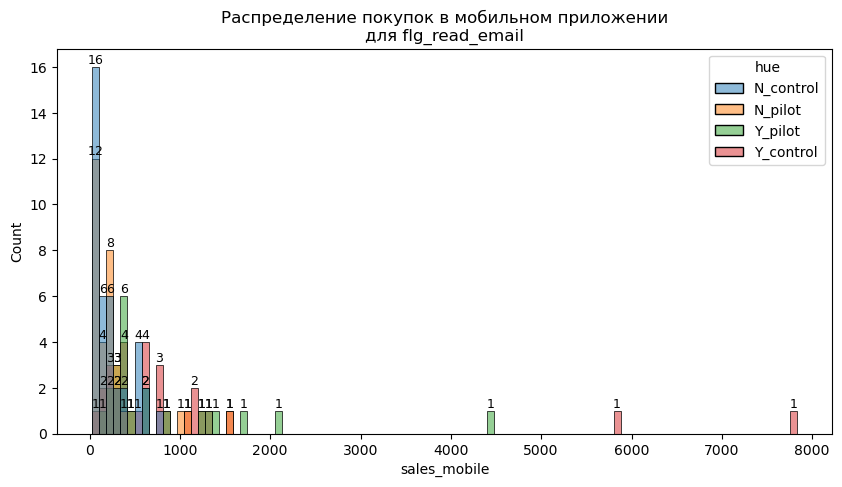

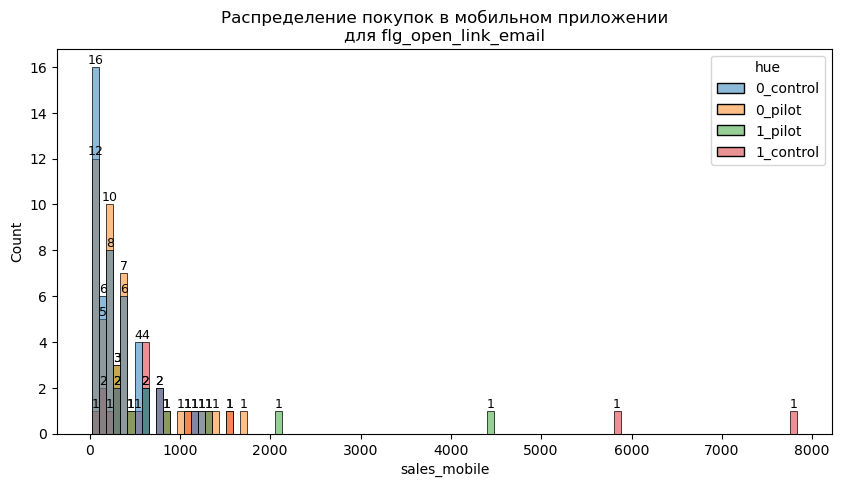

In [8]:
for column in ['group'] + list(data.columns[2:5]):
    plt.figure(figsize=(10, 5))
    data['hue'] = data.apply(lambda row: f"{row[column]}_{row['group']}", axis=1)
    
    ax = sns.histplot(data, x='sales_mobile', hue='hue', bins=100)

    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.title(f'Распределение покупок в мобильном приложении\nдля {column}')
    plt.show()

In [9]:
#заполним пропуски
data.fillna(0, inplace=True)

**Смотрим статистику по группам**

In [10]:
data.groupby(['group'])['sales_mobile'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
group,,,,
control,5231,7.656280,0.0,147.503745
pilot,5231,5.072644,0.0,87.620305


**Смотрим статистику в группах в зависимости от прочтения письма**

In [11]:
data.groupby(['group', 'flg_read_email'])['sales_mobile'].agg(['count', 'mean', 'median', 'std'])

count       mean  median         std
group   flg_read_email                                      
control N                4060   2.235222     0.0   29.327018
        Y                1171  26.451751     0.0  306.297063
pilot   N                3996   2.048298     0.0   37.272160
        Y                1235  14.858300     0.0  167.079136

**Смотрим статисттику в группах в зависимости от перехода по ссылке**

In [12]:
data.groupby(['group', 'flg_open_link_email'])['sales_mobile'].agg(['count', 'mean', 'median', 'std'])

count        mean  median         std
group   flg_open_link_email                                       
control 0                     4977    2.860157     0.0   39.299561
        1                      254  101.633858     0.0  640.367968
pilot   0                     5010    3.062874     0.0   50.589804
        1                      221   50.633484     0.0  349.374189

**Смотрим конверсии в заказ**

In [13]:
data['ctr'] = (data['sales_mobile']>0)*1
data.groupby('group')['ctr'].agg(['mean'])

,mean
group,
control,0.013191
pilot,0.010132


In [14]:
#проверим попал ли один пользователь в разные группы
data.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


## Вывод:
- **Посмотрели распределение покупок в мобильном приложении, распределение скошенное, с пиком в нуле**
- **В группах по 5231 пользователю, основная часть покупок в диапазоне до двух тысяч, так же есть несколько больших значений, поэтому среднее и дисперсия неккоректно отображают положение дел, конверсии в покупку на уровне 1% в обоих группах, далее попробуем провести тест корректности затем бакетный тест**

### **$H_0-$  $\mu_{control} = \mu_{control}$**
### **$H_1-$  $\mu_{control} \neq \mu_{control}$**
### **$\alpha = 0.05$**

## mannwhitneyu A/A тест

In [15]:
mannwhitneyu(data[data['group']=='control']['sales_mobile'], 
          data[data['group']=='control']['sales_mobile'])

MannwhitneyuResult(statistic=13681680.5, pvalue=1.0)

## ttest A/A тест

In [16]:
#для контрольной группы
ttest_ind(data[data['group']=='control']['sales_mobile'], 
          data[data['group']=='control']['sales_mobile'], equal_var=False)

Ttest_indResult(statistic=0.0, pvalue=1.0)

#### Вывод:
- **Проверили с помощью статистических тестов что различий на момент проведения теста в поведении пользователей нет**

## A/B тест
---

### mannwhitneyu 

In [17]:
mannwhitneyu(data[data['group']=='control']['sales_mobile'], 
          data[data['group']=='pilot']['sales_mobile'])

MannwhitneyuResult(statistic=13723568.5, pvalue=0.14473996638844117)

###  ttest

In [18]:
ttest_ind(data[data['group']=='control']['sales_mobile'], 
          data[data['group']=='pilot']['sales_mobile'], equal_var=False)

Ttest_indResult(statistic=1.089166021495717, pvalue=0.27611151349489704)

# Бакетный тест

### **$H_0-$  $\mu_{control} = \mu_{pilot}$**
### **$H_1-$  $\mu_{control} \neq \mu_{pilot}$**
### **$\alpha = 0.05$**

In [19]:
#разделим пользователей на 100 бакетов по id и флагу прочтения письма 
num_buckets = 100

data['bucket'] = (data.apply(lambda row:                           
                  int(hashlib.md5(f"{row['user_id']}_{row['flg_read_email']}".encode()).hexdigest(), 16) % num_buckets, 
                                                                                                                 axis=1)
                 )

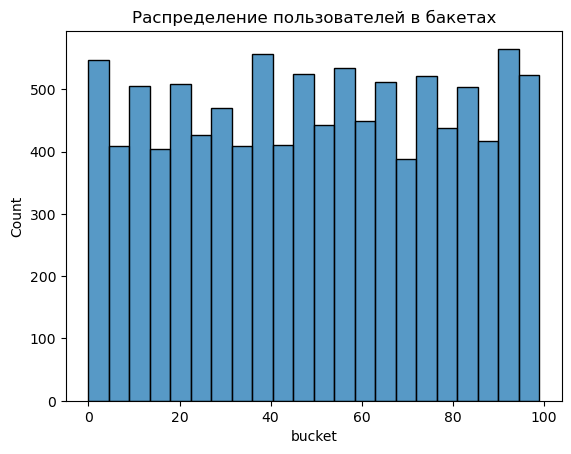

In [20]:
sns.histplot(data['bucket'])
plt.title('Распределение пользователей в бакетах')
plt.show()

In [21]:
bucket_data = data.groupby(['group', 'bucket'])['sales_mobile'].sum().reset_index()
bucket_data

,group,bucket,sales_mobile
0,control,0,540.0
1,control,1,150.0
2,control,2,0.0
3,control,3,100.0
4,control,4,200.0
...,...,...,...
195,pilot,95,300.0
196,pilot,96,2160.0
197,pilot,97,0.0
198,pilot,98,250.0


In [22]:
#проверим разбиение
bucket_data['group'].value_counts()

control    100
pilot      100
Name: group, dtype: int64

In [23]:
#статистики до разделения на бакеты
data.groupby('group')['sales_mobile'].agg(['count', 'mean', 'median', 'std']).reset_index()

,group,count,mean,median,std
0,control,5231,7.656280,0.0,147.503745
1,pilot,5231,5.072644,0.0,87.620305


In [24]:
#статистики после разделения на бакеты
bucket_data.groupby('group')['sales_mobile'].agg(['count', 'mean', 'median', 'std']).reset_index()

,group,count,mean,median,std
0,control,100,400.50,82.5,1061.034253
1,pilot,100,265.35,0.0,671.490222


---

In [25]:
#конверсии до разделения на бакеты
data.groupby('group')['ctr'].agg(['mean'])

,mean
group,
control,0.013191
pilot,0.010132


In [26]:
#конверсии после разделения на бакеты
bucket_data['ctr'] = (bucket_data['sales_mobile']>0)*1
bucket_data.groupby('group')['ctr'].agg(['mean'])

,mean
group,
control,0.54
pilot,0.38


### mannwhitneyu + бакетное разделение

In [27]:
mannwhitneyu(bucket_data[bucket_data['group']=='control']['sales_mobile'], 
             bucket_data[bucket_data['group']=='pilot']['sales_mobile'])

MannwhitneyuResult(statistic=5828.0, pvalue=0.02759860115681885)

### ttest_ind + бакетное разделение

In [28]:
ttest_ind(bucket_data[bucket_data['group']=='control']['sales_mobile'], 
          bucket_data[bucket_data['group']=='pilot']['sales_mobile'], equal_var=False)

Ttest_indResult(statistic=1.0763227180362878, pvalue=0.2833322414538402)

In [29]:
bs = stats.bootstrap(data=(bucket_data['sales_mobile'].values,),
          statistic=np.mean,
          confidence_level=0.95,
          n_resamples=100000,
          method='percentile').confidence_interval
print('Нижняя граница:', round(bs.low, 3), 'Верхняя граница:', round(bs.high, 3)) 
print('delta: ',bs.high - bs.low)

Нижняя граница: 223.149 Верхняя граница: 467.001
delta:  243.8512499999998


In [30]:
res = []
for _ in tqdm(range(100_000)):
    sample = bucket_data['sales_mobile'].sample(200, replace=True)
    res.append(sample.mean())

  0%|          | 0/100000 [00:00<?, ?it/s]

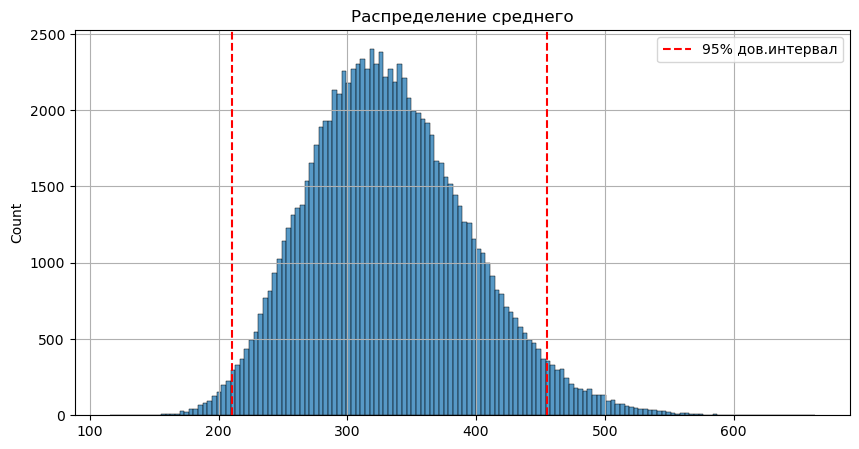

In [31]:
plt.figure(figsize=(10, 5))
sns.histplot(res, legend=True,)
plt.axvline(np.mean(res) - 1.96*np.std(res), color='r', linestyle='--', label='95% дов.интервал')
plt.axvline(np.mean(res) + 1.96*np.std(res), color='r', linestyle='--')
plt.title('Распределение среднего')
plt.legend()
plt.grid()
plt.show()

---
$\hat{mu} \pm 1.96 * \hat{std}$

In [32]:
# 95 % доверительный интервал по формуле
print('Нижняя граница:',round(np.mean(res) - 1.96*np.std(res), 3), 
      'Верхняя граница:',round(np.mean(res) + 1.96*np.std(res), 3))

Нижняя граница: 210.101 Верхняя граница: 455.455


In [33]:
#посмотрим как распределены выборочные средние в группах
a_ctr = []
b_pil = []

n = 10_000

for _ in tqdm(range(n)):
    a = bucket_data[bucket_data['group']=='control']['sales_mobile'].sample(100, replace=True)
    b = bucket_data[bucket_data['group']=='pilot']['sales_mobile'].sample(100, replace=True)
    a_ctr.append(a.mean())
    b_pil.append(b.mean())

  0%|          | 0/10000 [00:00<?, ?it/s]

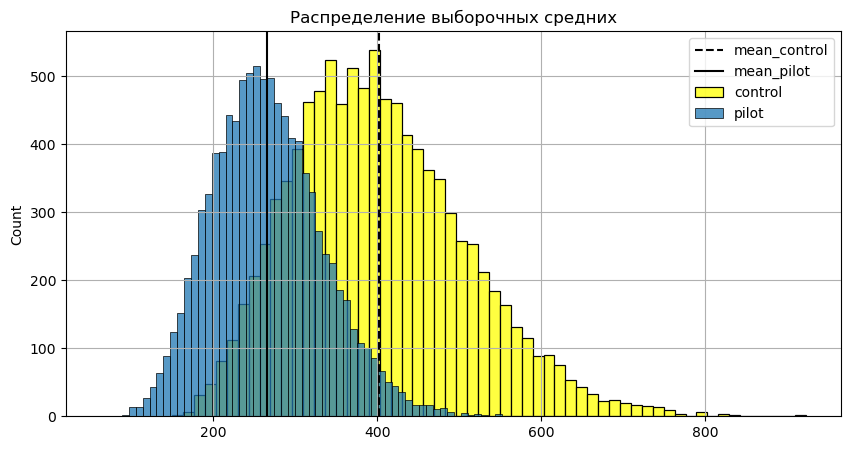

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(a_ctr,color='yellow', label='control')
sns.histplot(b_pil, label='pilot')
plt.grid()
plt.axvline(np.mean(a_ctr), color='black', linestyle='--', label='mean_control')
plt.axvline(np.mean(b_pil), color='black', linestyle='-', label='mean_pilot')
plt.legend()
plt.title('Распределение выборочных средних')
plt.show()

## Итоговый вывод:
- **Познакомились с данными, распределение в данных скошено влево, с пиком в нуле, большая часть данных находится в диапазоне до двух тысяч, так же есть несколько пользователей с покупками более четырех тысяч**


- **Провели ttest и тест mannwhitneyu на исходных данных получили pvalue 0.276 и 0.144 соответственно, далее будем использовать тест mannwhitneyu потому что у нас несколько пользователей с заказами более двух тысяч, когда основная часть с чеками до двух тысяч, тест mannwhitneyu не чувствителен к выбросам**


- **Увеличили чувствительность с помощью бакетного теста, разделили пользователей на 100 бакетов в качестве salt использовали id пользователя и флаг прочтения письма, получили более адекватные средние и дисперсию: среднее в контрольной группе = 400, в пилотной 265, до бакетирования 7 и 5**


- **Посчитали доверительный интервал для среднего, можно на это посмотреть как если бы мы провели еще сто a/b тест, то с 95% вероятностью истинное среднее будет находиться в интервале в нашем случае от 220 до 455**


**Решение:**
---
- **Значение pvalue полученное на тесте mannwhitneyu меньше выбранного уровня значимости 0.02 < 0.05, отвергаем $H_0$ о равенстве средних между группами, среднее в группах control=400р, pilot=265р, среднее в пилотной группе ниже. Проверили конверсию в заказ в группах после бакетирования control=0.54, pilot=0.38, конверсия в пилотной группе ниже. `По итогу предлагаю отказаться от внедрения нового макета.` Так же чтобы снизить дисперсию в данных и повысить чувствительность(уверенность теста) возможны следующие варианты: добавить продажи за предпериод и использовать cuped, и нет информации стратифицировались ли пользователи во время эксперимента, если нет то можно провести пост стратификацию.**


- **Таблица с результатами**

|statistics|before bucket|after bucket|
|----------|----------|----------|
| **Mean** |**control=7, pilot=5**|**control=400, pilot=265**|
| **Std**  |**control=147, pilot=87**|**control=1061, pilot=671**|
| **Ctr**  |**control=1.3%, pilot=1%**|**control=54%, pilot=38%**|
